# Example: Obtaining results from the eq and profiles objects

Here we will take a look at how to access different results stored (or calculated using methods) in the `eq` and `profiles` objects. 

To do this we first need to run a static forward simulation in the MAST-U-like tokamak using previously saved coil currents to generate our results. Of course, the same methods below can be applied after an inverse solve!

## Static forward simulation

No probe configuration is provided


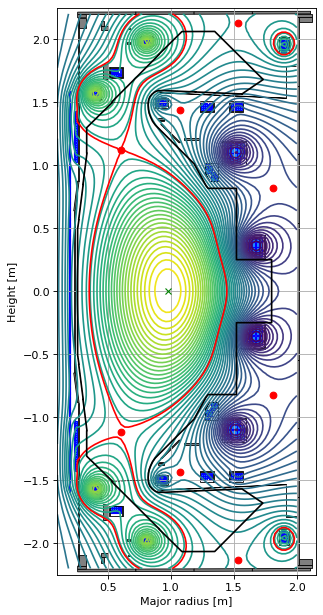

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"


# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak()

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Dashboard of results

It is worth playing around with the fields/methods in the `eq` and `profiles` objects yourself to see which quantities can be calculated from the plasma equilibrium using built-in functionality. Below, we provide a mini dashboard of different quantities and how to generate them. 

If there are certain quantites that you wish to be added that don't exist within FreeGSNKE at the moment, please do submit a feature request to the Github repository.

#### General equillibrium quantites
Here, we display a number of  used equilibrium quantites. 

In [2]:
# plasma quantities
print(rf"Plasma current: {eq.plasmaCurrent()} [A]")
print("---")
print(rf"Poloidal beta (definition 1): {eq.poloidalBeta()}")
print(rf"Poloidal beta (definition 2): {eq.poloidalBeta2()}")
print(rf"Toroidal beta: {eq.toroidalBeta()}")
print(rf"Normalised total beta: {eq.normalised_total_Beta()}")
print("---")
print(fr"Plasma internal inductance (li1): {eq.internalInductance1()}")
print(fr"Plasma internal inductance (li2): {eq.internalInductance2()}")
print(fr"Plasma internal inductance (li3): {eq.internalInductance3()}")

Plasma current: 620000.0000000001 [A]
---
Dicrepancy between psi_func and plasma_psi detected. psi_func has been re-set.
Poloidal beta (definition 1): 0.1942878800929916
Poloidal beta (definition 2): 0.28444920385834843
Toroidal beta: 0.014831971435683412
Normalised total beta: 0.014096918933791837
---
Plasma internal inductance (li1): 1.0062271980346806
Plasma internal inductance (li2): 0.6523381264105635
Plasma internal inductance (li3): 0.7104834654945219


In [3]:
# plasma geometry quantities
print(rf"Minor radius: {eq.minorRadius()} [m]")
print("---")
print(rf"Magnetic axis location: {eq.magneticAxis()[0:2]} [m]")
print(rf"Geometric axis location: {eq.geometricAxis()} [m]")
print(rf"Shafranov shift: {eq.shafranov_shift()} [m]")
print(rf"Inner and outer mipdplane (Z=0) radii: {eq.innerOuterSeparatrix(Z=0)} [m]")
print(rf"Inner and outer mipdplane (Z=0) radii (alternative): {eq.innerOuterSeparatrix2(Z=0)} [m]")

print("---")
print(rf"LCFS circumference: {eq.separatrix_length()} [m]")
print(rf"LCFS area: {eq.separatrix_area()} [m^2]")
print(rf"Plasma volume: {eq.plasmaVolume()} [m^3]")

print("---")
print(rf"Aspect ratio: {eq.aspectRatio()}")

print("---")
print(rf"Geometric elongation: {eq.geometricElongation()}")
print(rf"Geometric elongation (upper): {eq.geometricElongation_upper()}")
print(rf"Geometric elongation (lower): {eq.geometricElongation_lower()}")
print(rf"Effective elongation: {eq.effectiveElongation()}")

print("---")
print(rf"Triangularity: {eq.triangularity()}")
print(rf"Triangularity (upper): {eq.triangularity_upper()}")
print(rf"Triangularity (lower): {eq.triangularity_lower()}")

print("---")
s_uo, s_ui, s_lo, s_li = eq.squareness()
print(rf"Squareness (upper outer): {s_uo}")
print(rf"Squareness (upper inner): {s_ui}")
print(rf"Squareness (lower outer): {s_lo}")
print(rf"Squareness (lower inner): {s_li}")

print("---")
L = eq.closest_wall_point()
print(rf"Point on wall that is closest to the LCFS: {L[0]} [m]")
print(rf"Corresponding distance from point to LCFS: {L[1]} [m]")

print("---")
print(rf"Is this a limited plasma?: {eq.flag_limiter}")
print(rf"Does the core plasma boundary intersect the wall?: {eq.intersectsWall()}")



Minor radius: 0.5459372943389025 [m]
---
Magnetic axis location: [0.9790111  0.00357158] [m]
Geometric axis location: [0.89888969 0.02007391] [m]
Shafranov shift: [ 0.0801214  -0.01650233] [m]
Inner and outer mipdplane (Z=0) radii: (0.3526043263251836, 1.4449530513603244) [m]
Inner and outer mipdplane (Z=0) radii (alternative): [(0.35296163765953736, 0.0), (1.4448134893247466, 0.0)] [m]
---
LCFS circumference: 5.246886560004773 [m]
LCFS area: 1.7434336159993524 [m^2]
Plasma volume: 9.419826240114775 [m^3]
---
Aspect ratio: 1.6465072130155367
---
Geometric elongation: 2.0113113142287475
Geometric elongation (upper): 2.041538828812685
Geometric elongation (lower): 1.9810837996448105
Effective elongation: 1.781235015710443
---
Triangularity: 0.4877477868835827
Triangularity (upper): 0.4589187488768923
Triangularity (lower): 0.5165768248902731
---
Squareness (upper outer): -0.09422769600542269
Squareness (upper inner): 0.7209659624218064
Squareness (lower outer): -0.08507431990581103
Squar

In [4]:
# extract the plasma core boundary (specify the number of points you want)
eq.separatrix(ntheta=20) 

array([[ 0.9790111 ,  0.94151299],
       [ 1.21241495,  0.72191478],
       [ 1.33475841,  0.49321576],
       [ 1.3856118 ,  0.29898429],
       [ 1.42520154,  0.14854765],
       [ 1.44482699,  0.00357158],
       [ 1.42606891, -0.14168631],
       [ 1.3859786 , -0.29210761],
       [ 1.33451399, -0.48573618],
       [ 1.2127845 , -0.71590896],
       [ 0.9790111 , -0.93444733],
       [ 0.62885065, -1.07411144],
       [ 0.46338764, -0.70612321],
       [ 0.39162193, -0.42319163],
       [ 0.36130351, -0.19713378],
       [ 0.3529524 ,  0.00357158],
       [ 0.36114718,  0.20432774],
       [ 0.3912038 ,  0.43063858],
       [ 0.46219328,  0.71491028],
       [ 0.61687114,  1.11812377]])

In [11]:
# extract some key metrics of the plasma core boundary (these points mark the extreme points on the boundary, see plot below)
eq._separatrix_metrics()
Rmin = eq._sep_Rmin
Rmax = eq._sep_Rmax
Zmin = eq._sep_Zmin
Zmax = eq._sep_Zmax
ZRmin = eq._sep_ZRmin
ZRmax = eq._sep_ZRmax
RZmin = eq._sep_RZmin
RZmax = eq._sep_RZmax
area = eq._sep_area
length = eq._sep_length


In [12]:
# extract the X points (R, Z, psi)
eq.xpt

array([[ 0.60617512,  1.12198256,  0.0301763 ],
       [ 0.60646059, -1.11753886,  0.02994727],
       [ 1.53249151,  2.13022363,  0.02133572],
       [ 1.53261754, -2.13078585,  0.02128122],
       [ 1.07297132,  1.43535304,  0.00796862],
       [ 1.07279087, -1.43485753,  0.00782552],
       [ 1.80833121,  0.8210237 , -0.02111794],
       [ 1.80722307, -0.82101387, -0.02124752]])

In [13]:
# extract the O points (R, Z, psi)
eq.opt

array([[0.9790111 , 0.00357158, 0.09743898]])

In [14]:
# extract the strike points where the separatric intersects the wall, if any (R, Z)
eq.strikepoints()

array([[ 1.11659132, -2.06603637],
       [ 0.332797  , -1.25932104],
       [ 0.332797  ,  1.25736488],
       [ 1.11924703,  2.05957332]])

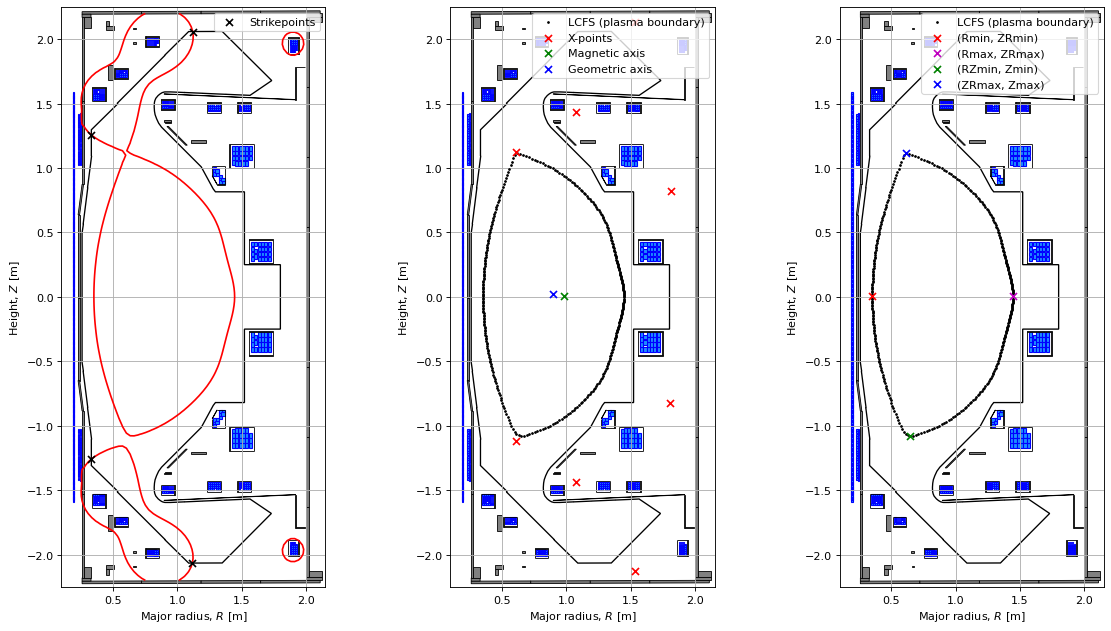

In [15]:
# here we plot some of the features above on different axes to show where they are located (see code documentation for more details)

sep = eq.separatrix(ntheta=360)
strikes = eq.strikepoints()

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.25)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax1.scatter(strikes[:,0], strikes[:,1], color='k', marker='x', s=40, zorder=2, label="Strikepoints")
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
ax1.legend(loc="upper right")





ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax2.scatter(sep[:,0], sep[:,1], color='k', marker='o', s=2, zorder=2, label="LCFS (plasma boundary)")
ax2.scatter(eq.xpt[:,0], eq.xpt[:,1], color='r', marker='x', s=40, zorder=2, label="X-points")
ax2.scatter(eq.magneticAxis()[0], eq.magneticAxis()[1], color='g', marker='x', s=40, zorder=2, label="Magnetic axis")
ax2.scatter(eq.geometricAxis()[0], eq.geometricAxis()[1], color='b', marker='x', s=40, zorder=2, label="Geometric axis")
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
ax2.legend(loc="upper right")





ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax3.scatter(sep[:,0], sep[:,1], color='k', marker='o', s=2, zorder=2, label="LCFS (plasma boundary)")
ax3.scatter(Rmin, ZRmin, color='r', marker='x', s=40, zorder=2, label="(Rmin, ZRmin)")
ax3.scatter(Rmax, ZRmax, color='m', marker='x', s=40, zorder=2, label="(Rmax, ZRmax)")
ax3.scatter(RZmin, Zmin, color='g', marker='x', s=40, zorder=2, label="(RZmin, Zmin)")
ax3.scatter(RZmax, Zmax, color='b', marker='x', s=40, zorder=2, label="(ZRmax, Zmax)")
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
ax3.legend(loc="upper right")

plt.tight_layout()

#### Flux quantites
Here, we plot the total poloidal flux $\psi$ [Webers / $2\pi$] and its two components $\psi_p$ (the plasma flux) and $\psi_c$ (the coil flux): $\psi = \psi_p + \psi_c$. 

In [16]:
# # many different ways to call things

# # total psi
# eq.psi()
# eq.psiRZ(R=1,Z=0)
# eq.psiRZ(R=eq.R,Z=eq.Z)

# # plasma psi
# eq.plasma_psi
# eq.psi_func(R=0, Z=1)
# eq.psi_func(R=eq.R,Z=eq.Z, grid=False)

# # tokamak psi (coil flux)
# eq.tokamak_psi
# eq.tokamak.psi(R=0, Z=1)
# eq.tokamak.psi(R=eq.R,Z=eq.Z)


# # normalised total psi
# eq.psiNRZ(R=1,Z=0)
# eq.psiNRZ(R=eq.R,Z=eq.Z)

# # psi on axis and boundary
# eq.psi_axis
# eq.psi_bndry

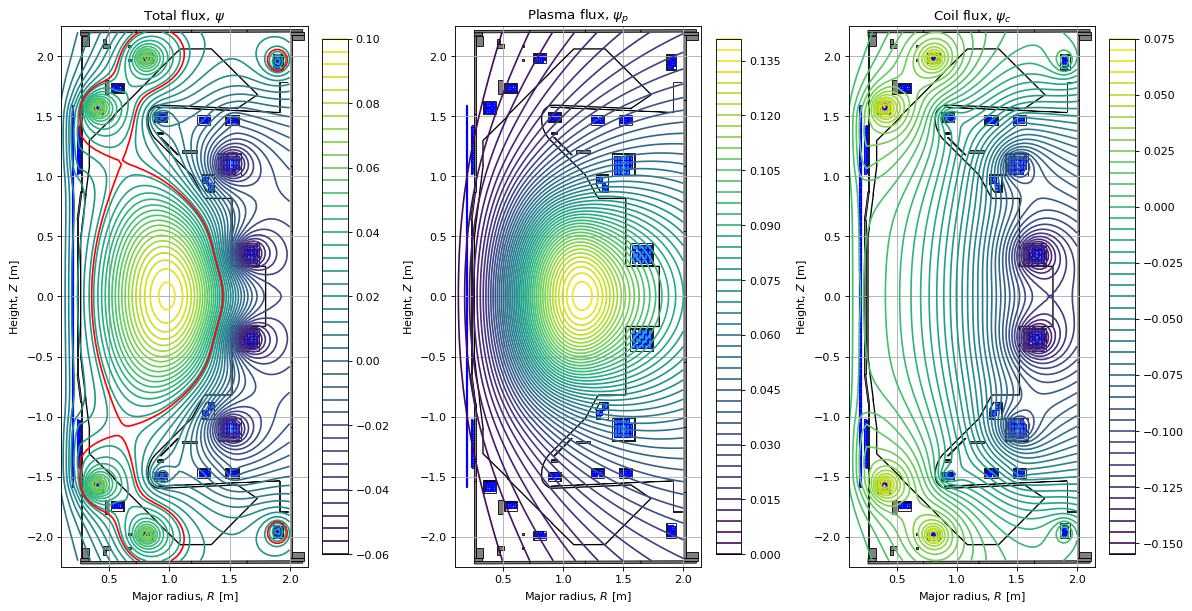

In [17]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.psi(), levels=50)                          # total psi
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')  # psi boundary contour
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Total flux, $\psi$")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasma_psi, levels=50)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"Plasma flux, $\psi_p$")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.tokamak_psi, levels=50)                          # coil psi
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"Coil flux, $\psi_c$")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

We can also extract the flux produced by individual coils (or pasive structures) if required. We do this my using the pre-calculated Green's functions, the coil currents, multipliers, and polarities. 

In [18]:
currents = eq.tokamak.getCurrents()

# calculate the active/passive coil fluxes

psi_coils = dict()
for i, name in enumerate(currents.keys()):
    coil = eq.tokamak.coils_dict[name]
    scaling = coil["multiplier"]*coil["polarity"]
    greens_matrix = 0.0
    
    if type(eq._pgreen[name]) is dict:
        num_coils = len(eq._pgreen[name])
        for i, ind in enumerate(eq._pgreen[name]):
            greens_matrix += eq._pgreen[name][ind]*scaling[i*(len(scaling)//num_coils)]
    else:
        num_coils = 1
        greens_matrix = eq._pgreen[name]*scaling[0]

    psi_coils[name] = greens_matrix*currents[name]

Here, we plot a few of the fluxes from the coils. You can change the `name` parameters to visualise different coil fluxes.

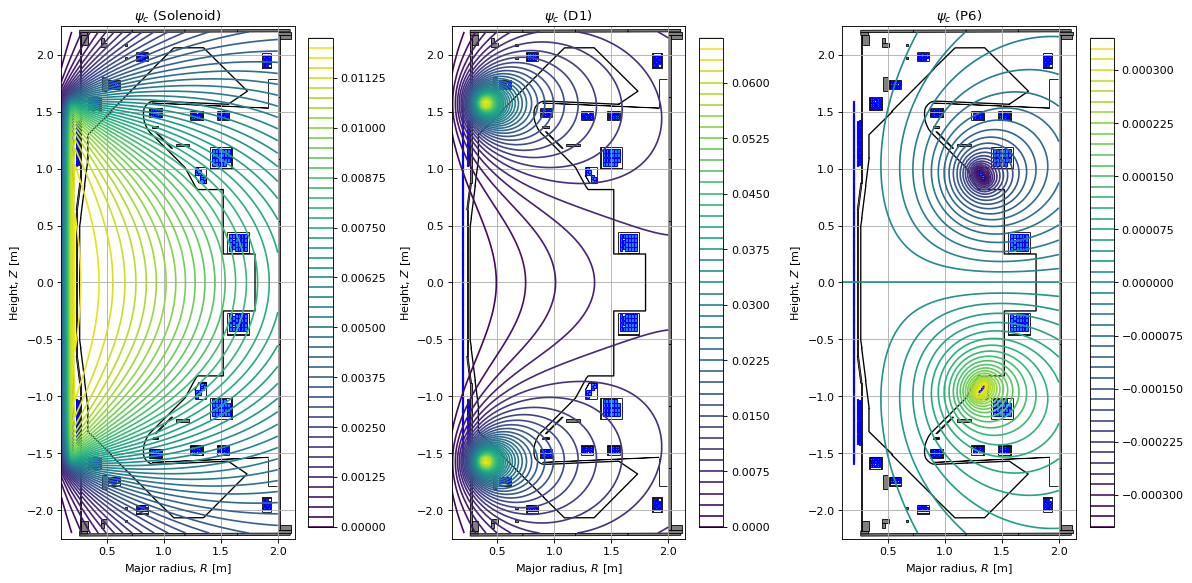

In [19]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

name = "Solenoid"
ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(rf"$\psi_c$ ({name})")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

name = "D1"
ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(rf"$\psi_c$ ({name})")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)

name = "P6"
ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(rf"$\psi_c$ ({name})")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

#### Magnetic fields

Here, we plot the different magnetic field components over the domain.

In [20]:
# # many different ways to call things

# # total radial field
# eq.Br(R=1,Z=0)
# eq.Br(R=eq.R,Z=eq.Z)

# # total vertical field
# eq.Bz(R=1,Z=0)
# eq.Bz(R=eq.R,Z=eq.Z)

# # toroidal field
# eq.Btor(R=1,Z=0)
# eq.Btor(R=eq.R,Z=eq.Z)

# # total poloidal field
# eq.Bpol(R=1,Z=0)
# eq.Bpol(R=eq.R,Z=eq.Z)



# # plasma radial field
# eq.plasmaBr(R=1,Z=0)
# eq.plasmaBr(R=eq.R,Z=eq.Z)

# # plasma vertical field
# eq.plasmaBz(R=1,Z=0)
# eq.plasmaBz(R=eq.R,Z=eq.Z)

# # tokamak radial field (coils)
# eq.tokamak.Br(R=1,Z=0)
# eq.tokamak.Br(R=eq.R,Z=eq.Z)

# # tokamak vertical field (coils)
# eq.tokamak.Bz(R=1,Z=0)
# eq.tokamak.Bz(R=eq.R,Z=eq.Z)

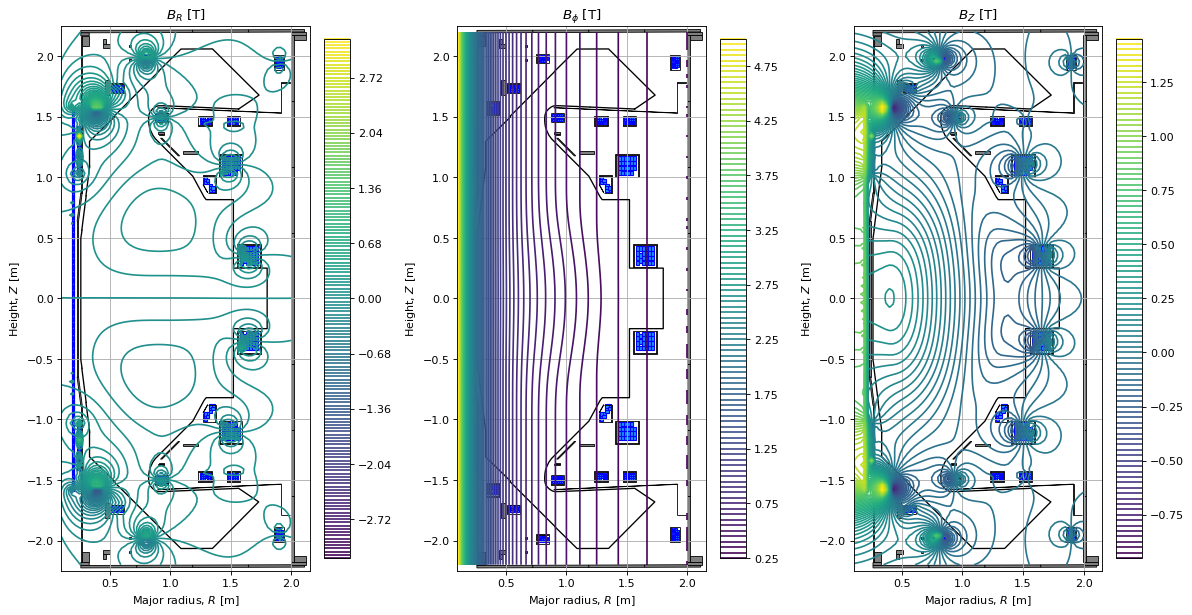

In [21]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.Br(eq.R, eq.Z), levels=200)                          
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.Btor(eq.R, eq.Z), levels=100)                          
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_{\phi}$ [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.Bz(eq.R, eq.Z), levels=100)                          
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"$B_Z$ [T]")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

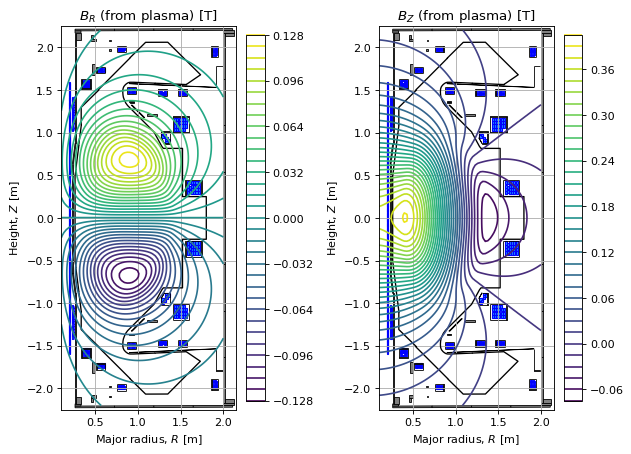

In [22]:
# this is just the contribution from the plasma
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.plasmaBr(eq.R, eq.Z), levels=30)                        
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from plasma) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasmaBz(eq.R, eq.Z), levels=30)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from plasma) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

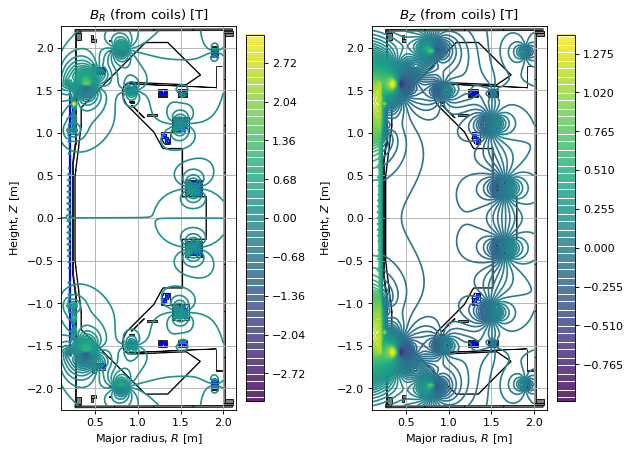

In [23]:
# this is just the contribution from the coils
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.tokamak.Br(eq.R, eq.Z), levels=200)                         
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from coils) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.tokamak.Bz(eq.R, eq.Z), levels=200)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from coils) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

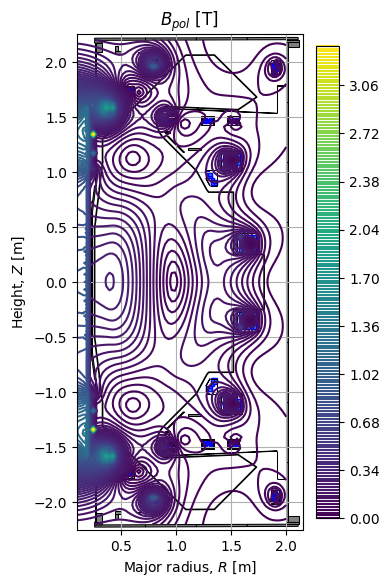

In [24]:
# total poloidal magnetic field

fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=100)

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.Bpol(eq.R, eq.Z), levels=200)                       
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_{pol}$ [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

plt.tight_layout()

#### Coil currents

Here, we visualise the size of the currents in the poloidal field coils.

In [25]:
# listing the currents may not be that informative 
eq.tokamak.getCurrents()

{'Solenoid': 5000,
 'PX': 3651.0769901740773,
 'D1': 8942.539917412247,
 'D2': -616.2886050111157,
 'D3': 5143.623600621425,
 'Dp': -2345.683712883073,
 'D5': 1049.5821472120365,
 'D6': 81.22652499448158,
 'D7': -412.8759370829901,
 'P4': -3569.2766996309892,
 'P5': -4021.3241912097365,
 'P6': -37.84574081996122,
 'vessel_1': 0,
 'vessel_2': 0,
 'vessel_3': 0,
 'vessel_4': 0,
 'vessel_5': 0,
 'vessel_6': 0,
 'vessel_7': 0,
 'vessel_8': 0,
 'vessel_9': 0,
 'vessel_10': 0,
 'vessel_11': 0,
 'vessel_12': 0,
 'vessel_13': 0,
 'vessel_14': 0,
 'vessel_15': 0,
 'vessel_16': 0,
 'vessel_17': 0,
 'vessel_18': 0,
 'vessel_19': 0,
 'vessel_20': 0,
 'vessel_21': 0,
 'vessel_22': 0,
 'centrecolumn_1': 0,
 'centrecolumn_2': 0,
 'centrecolumn_3': 0,
 'centrecolumn_4': 0,
 'centrecolumn_5': 0,
 'centrecolumn_6': 0,
 'centrecolumn_7': 0,
 'centrecolumn_8': 0,
 'centrecolumn_9': 0,
 'centrecolumn_10': 0,
 'colosseum_upper_1': 0,
 'colosseum_upper_2': 0,
 'colosseum_upper_3': 0,
 'colosseum_lower_1': 0,

You can play around with the colour schemes below to visualise how the current is distributed around the machine. Note here that there is no current in the passive structures but they can be included if present. 

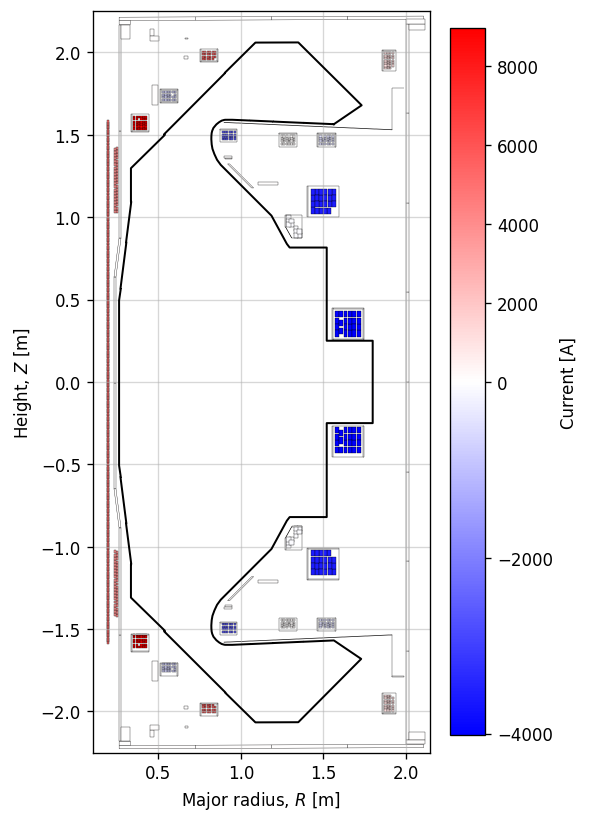

In [26]:
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm



# create colormap based on magnitude of currents
currents_array = []
for key in list(eq.tokamak.coils_dict.keys()):
    currents_array.append(eq.tokamak[key].current)

max_curr = np.max(np.abs(currents_array))
# norm = Normalize(vmin=-max_curr, vmax=max_curr) # alternative colorbar
norm = TwoSlopeNorm(vmin=np.min(currents_array), vcenter=0, vmax=np.max(currents_array))  
cmap = cm.bwr


# plot
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=120)
plt.tight_layout()
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')


for name in list(eq.tokamak.coils_dict.keys()):
    coil = eq.tokamak.coils_dict[name]
    current = eq.tokamak[name].current
    color = cmap(norm(current))  # map the current to a color
    
    # plot active coils (and currents)
    if coil["active"]:

        for i in range(0, len(coil["coords"][0,:])):
            patch = Rectangle(
                (coil["coords"][0,i] - coil["dR"] / 2, coil["coords"][1,i] - coil["dZ"] / 2),
                width=coil["dR"],
                height=coil["dZ"],
                facecolor=color,
                edgecolor='k',
                linewidth=0.2,
                )
            ax1.add_patch(patch)
    
    # plot passive structures (currents are zero here)        
    else:
        patch = Polygon(
            coil["vertices"].T, 
            facecolor=color, 
            edgecolor="k", 
            linewidth=0.2
        )
        ax1.add_patch(patch)


# add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig1.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.09)
cbar.set_label('Current [A]')

#### Forces on the coils

We can also extract the radial and vertical forces on the coils.

In [27]:
eq.printForces()

Forces on coils
Solenoid (circuit)
  Solenoid : R = 7966.40 kN , Z = 0.55 kN
PX (circuit)
  PX1 : R = 151.88 kN , Z = 14.86 kN
  PX2 : R = 151.62 kN , Z = -14.92 kN
D1 (circuit)
  D11 : R = 625.60 kN , Z = -103.70 kN
  D12 : R = 625.27 kN , Z = 103.53 kN
D2 (circuit)
  D21 : R = 1.46 kN , Z = 4.55 kN
  D22 : R = 1.47 kN , Z = -4.54 kN
D3 (circuit)
  D31 : R = 77.47 kN , Z = -2.13 kN
  D32 : R = 77.42 kN , Z = 2.07 kN
Dp (circuit)
  Dp1 : R = 37.30 kN , Z = -7.94 kN
  Dp2 : R = 37.31 kN , Z = 8.04 kN
D5 (circuit)
  D51 : R = 2.80 kN , Z = 1.90 kN
  D52 : R = 2.81 kN , Z = -1.90 kN
D6 (circuit)
  D61 : R = -0.50 kN , Z = 0.51 kN
  D62 : R = -0.50 kN , Z = -0.51 kN
D7 (circuit)
  D71 : R = 1.99 kN , Z = -4.45 kN
  D72 : R = 1.99 kN , Z = 4.45 kN
P4 (circuit)
  P41 : R = 64.20 kN , Z = 10.26 kN
  P42 : R = 64.28 kN , Z = -10.33 kN
P5 (circuit)
  P51 : R = 117.89 kN , Z = 14.56 kN
  P52 : R = 117.60 kN , Z = -14.74 kN
P6 (circuit)
  P61 : R = 0.32 kN , Z = 0.21 kN
  P62 : R = -0.32 kN , Z =

#### 1D plasma current density profiles (and others)
Here, we visualise the $p'$ and $FF'$ profiles used in our equilbirium solve. 

In [28]:
# # many different ways to call things

# # 1D poloidal flux profiles (between magetnic axis and plasma boundary)
# eq.psi_1D(N=101)
# eq.psiN_1D(N=101)

# # 1D toroidal flux profiles (between magetnic axis and plasma boundary)
# eq.rho_1D(N=101)
# eq.rhoN_1D(N=101)

# # pprime profile
# eq.pprime(psinorm=eq.psiN_1D(N=101))

# # pressure profile
# eq.pressure(psinorm=eq.psiN_1D(N=101))

# # ffprime profile
# eq.ffprime(psinorm=eq.psiN_1D(N=101))

# # fpol profile
# eq.fpol(psinorm=eq.psiN_1D(N=101))

# # q profile
# eq.q(psinorm=eq.psiN_1D(N=101))

Text(0, 0.5, "$FF'(\\hat{\\psi})$")

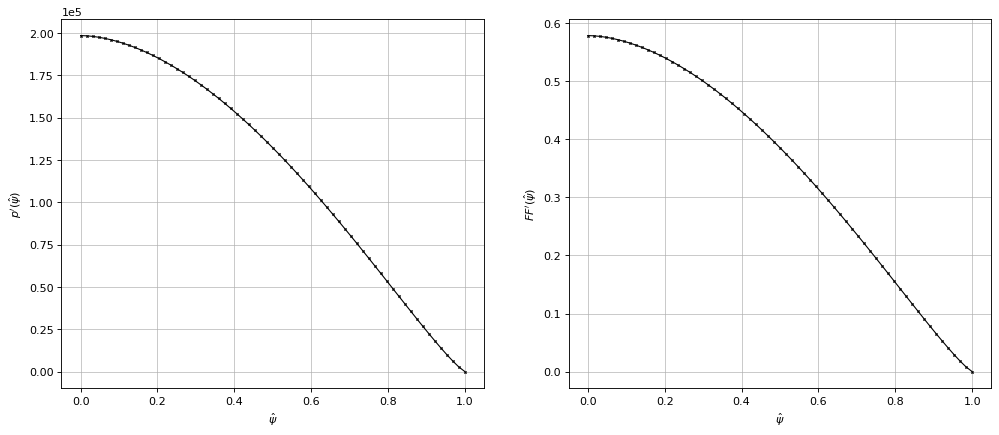

In [29]:
# plot the input p' and FF' profiles

psi_n = eq.psiN_1D(N=65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pprime(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p'(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, profiles.ffprime(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$FF'(\hat{\psi})$")


Text(0, 0.5, '$f_{pol}(\\hat{\\psi})$')

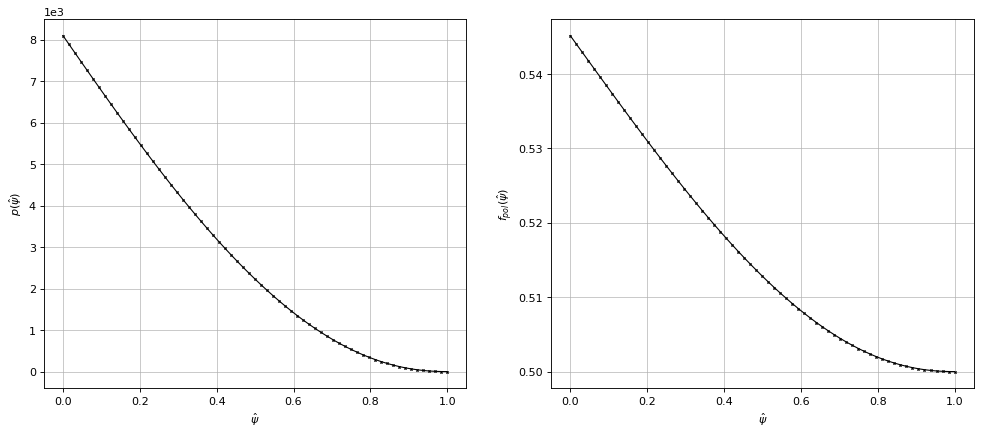

In [30]:
# plot the pressure and fpol profiles

psi_n = eq.psiN_1D(N=65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pressure(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, eq.fpol(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$f_{pol}(\hat{\psi})$")


Text(0, 0.5, '$q(\\hat{\\psi})$')

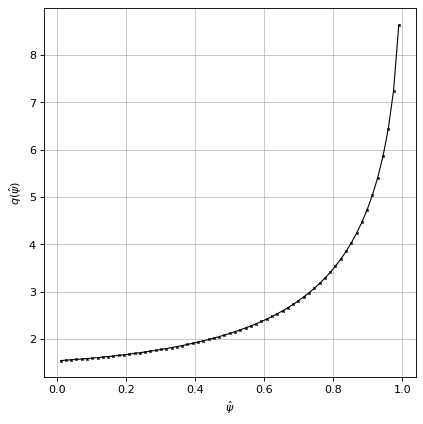

In [31]:
# plot q profile

psi_n = np.linspace(0.01,0.99,65)  # values of q at 0 and 1 can be problematic

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, eq.q(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$q(\hat{\psi})$")



#### Toroidal current density

Here, we visualise the toroidal current density inside the core of the plasma. 


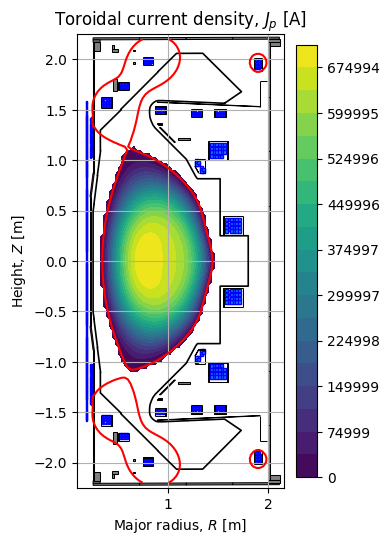

In [32]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=100)

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contourf(eq.R, eq.Z, eq._profiles.jtor, levels=np.linspace(0.01, np.max( eq._profiles.jtor,), 20))                        
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Toroidal current density, $J_p$ [A]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

plt.tight_layout()

### Masking arrays
There are a number of masking arrays that are built during the equilibrium solve that may be useful for plotting or other calculations you may carry out. 

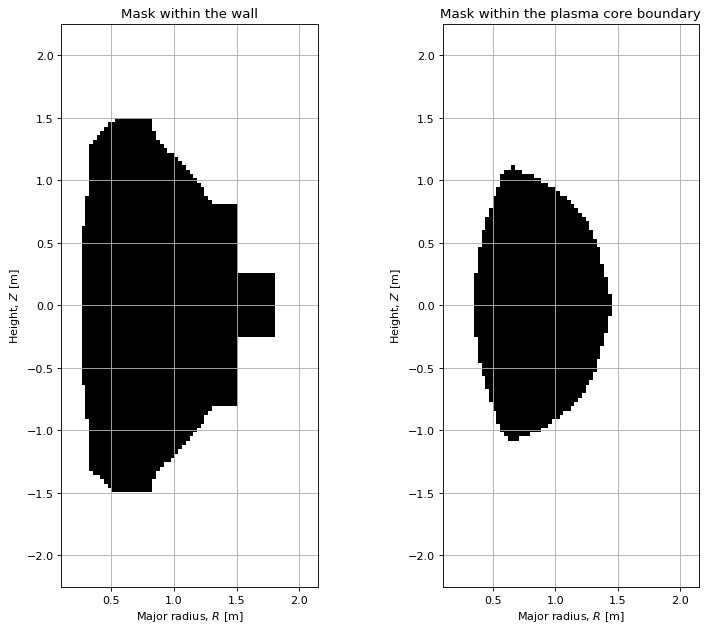

In [33]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), dpi=80)
plt.subplots_adjust(wspace=0.25)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
# eq.tokamak.plot(axis=ax1,show=False)
# ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor=None, zorder=0)
# ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax1.pcolormesh(eq.R, eq.Z, eq.mask_inside_limiter, cmap="Greys")
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
ax1.set_title("Mask within the wall")


ax2.grid(True, which='both')
# eq.tokamak.plot(axis=ax2,show=False)
# ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor=None, zorder=0)
# ax2.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax2.pcolormesh(eq.R, eq.Z, eq._profiles.diverted_core_mask, cmap="Greys")
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
ax2.set_title("Mask within the plasma core boundary")

plt.tight_layout()